Loading NumPy feature files (.npy)...
 Loaded 500 videos
Example X shape: (31, 699)
Example y: [0.36666667 0.5825243  0.34579438 0.47252747 0.375     ]
Example id: zEyRyTnIw5I.005.mp4
Train: 350 | Val: 75 | Test: 75


c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(


Epoch 1 | Train 0.0510 | Val 0.0200 | MSE 0.0198 | MAE 0.1129 | R² -0.0446 | Acc±0.1 53.07%
Epoch 2 | Train 0.0292 | Val 0.0188 | MSE 0.0189 | MAE 0.1104 | R² -0.0034 | Acc±0.1 51.47%
Epoch 3 | Train 0.0255 | Val 0.0182 | MSE 0.0180 | MAE 0.1058 | R² 0.0416 | Acc±0.1 56.27%
Epoch 4 | Train 0.0230 | Val 0.0198 | MSE 0.0194 | MAE 0.1126 | R² -0.0325 | Acc±0.1 52.53%
Epoch 5 | Train 0.0208 | Val 0.0207 | MSE 0.0202 | MAE 0.1137 | R² -0.0734 | Acc±0.1 52.00%
Epoch 6 | Train 0.0191 | Val 0.0218 | MSE 0.0213 | MAE 0.1156 | R² -0.1340 | Acc±0.1 50.67%
Epoch 7 | Train 0.0174 | Val 0.0213 | MSE 0.0210 | MAE 0.1160 | R² -0.1193 | Acc±0.1 52.00%
Epoch 8 | Train 0.0148 | Val 0.0226 | MSE 0.0216 | MAE 0.1164 | R² -0.1489 | Acc±0.1 50.67%
 Early stopping triggered


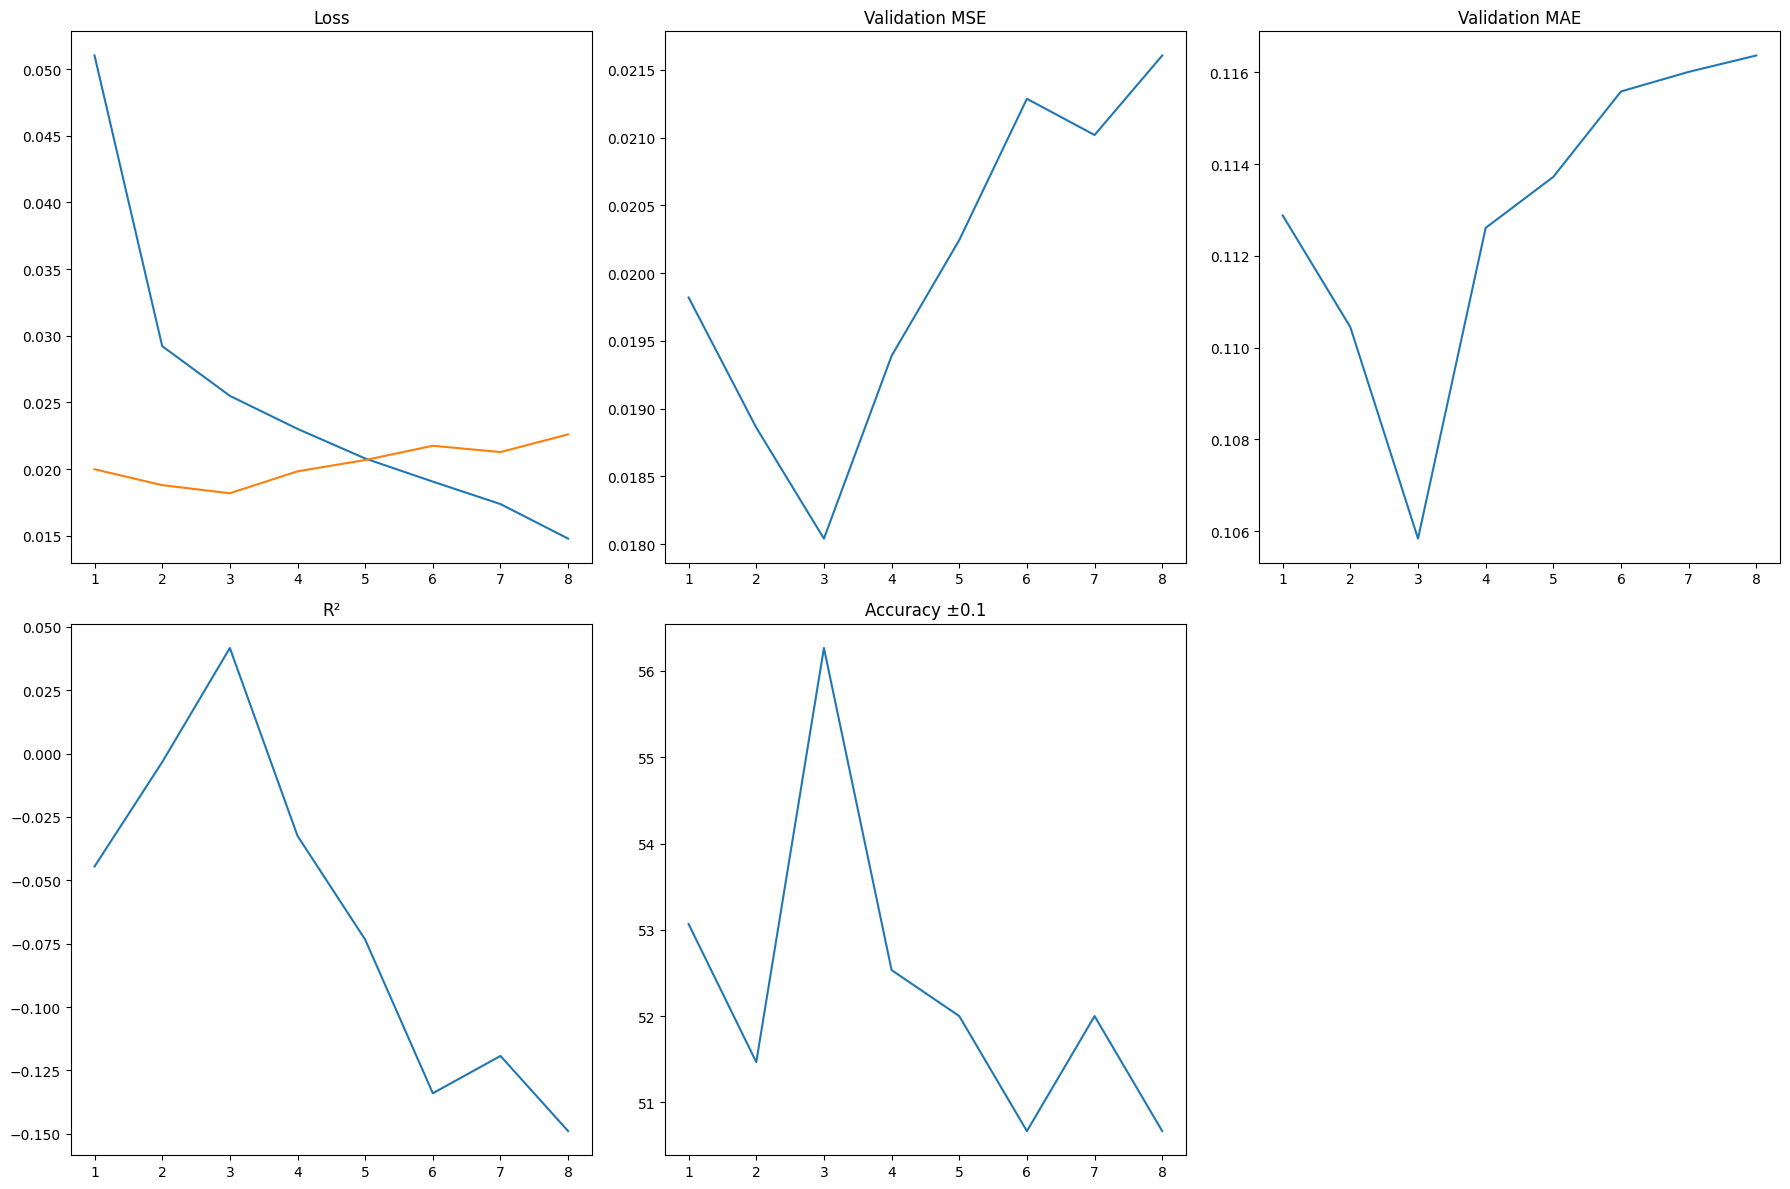


================= FINAL TEST RESULTS =================
MSE: 0.0190
MAE: 0.1118
R²:  -0.0307
Accuracy ±0.1: 52.27%


In [ ]:
# ============================================================
# 📦 Install & Imports (BiLSTM + Transformer)
# ============================================================

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



seq_X_path  = "seq_X.npy"
seq_y_path  = "seq_y.npy"
seq_id_path = "seq_id.npy"

print("Loading NumPy feature files (.npy)...")

# np.load is the correct function for .npy files
# seq_X_raw is an array of objects (variable-length sequences), so allow_pickle=True is needed.
seq_X_raw = np.load(seq_X_path, allow_pickle=True)
seq_y_raw = np.load(seq_y_path, allow_pickle=True)
seq_id = np.load(seq_id_path, allow_pickle=True)


# Convert to correct types
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y_cleaned = [arr[0] for arr in seq_y_raw] 
seq_y = np.array(seq_y_cleaned, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f" Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])


# ============================================================
# 📦 Dataset + Collate fn
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs  = [item["x"] for item in batch]
    ys  = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)


# ============================================================
# 📊 Train/Val/Test Split
# ============================================================
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 Cross-Attention Block
# ============================================================
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim, nhead=4, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(dim, nhead, dropout=dropout, batch_first=True)
        self.ln1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim*2),
            nn.ReLU(),
            nn.Linear(dim*2, dim)
        )
        self.ln2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, key_padding_mask=None):
        attn, _ = self.mha(q, k, v, key_padding_mask=key_padding_mask)
        x = self.ln1(q + self.dropout(attn))
        ff_out = self.ff(x)
        x = self.ln2(x + self.dropout(ff_out))
        return x


# ============================================================
# 🧠 BiLSTM + Transformer Multimodal Model
# ============================================================
class OceanBiLSTMTransformer(nn.Module):
    def __init__(self,
                 input_dim,
                 clip_dim=512,
                 wav_dim=187,
                 clip_enc_dim=128,
                 wav_enc_dim=128,
                 d_model=256,
                 dropout=0.2,
                 nhead_xattn=4,
                 nhead_transformer=8,
                 num_layers_transformer=2):
        super().__init__()

        self.clip_dim = clip_dim
        self.wav_dim = wav_dim
      

        # ------------ Encoders -------------
        self.clip_encoder = nn.Sequential(
            nn.Linear(clip_dim, clip_enc_dim), nn.ReLU(), nn.LayerNorm(clip_enc_dim)
        )
        self.wav_encoder = nn.Sequential(
            nn.Linear(wav_dim, wav_enc_dim), nn.ReLU(), nn.LayerNorm(wav_enc_dim)
        )

        # ------------ Cross Attention -------------
        self.cross_clip_from_audio = CrossAttentionBlock(clip_enc_dim, nhead_xattn, dropout)
        self.cross_audio_from_clip = CrossAttentionBlock(wav_enc_dim, nhead_xattn, dropout)

        fused_dim = clip_enc_dim + wav_enc_dim 

        self.fuse_proj = nn.Sequential(
            nn.Linear(fused_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
        )

        # ------------ BiLSTM -------------
        self.bilstm = nn.LSTM(
            d_model, d_model//2,
            batch_first=True,
            bidirectional=True
        )
        self.lstm_ln = nn.LayerNorm(d_model)

        # ------------ Transformer -------------
        self.cls_token = nn.Parameter(torch.randn(1,1,d_model))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead_transformer,
            dim_feedforward=512, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers_transformer)

        # ------------ Regression Head -------------
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5)
        )

    def forward(self, x, mask):
        B, T, D = x.shape

        # Split modalities
        x_clip = x[:, :, :self.clip_dim]
        x_wav  = x[:, :, self.clip_dim:self.clip_dim+self.wav_dim]

        # Encode
        e_clip = self.clip_encoder(x_clip)
        e_wav  = self.wav_encoder(x_wav)

        padding_mask = (mask==0)

        # Cross attention
        clip_ca = self.cross_clip_from_audio(e_clip, e_wav, e_wav, key_padding_mask=padding_mask)
        wav_ca  = self.cross_audio_from_clip(e_wav, e_clip, e_clip, key_padding_mask=padding_mask)

        fused = torch.cat([clip_ca, wav_ca,], dim=-1)
        fused = self.fuse_proj(fused)

        # BiLSTM
        lstm_out, _ = self.bilstm(fused)
        lstm_out = self.lstm_ln(lstm_out)

        # Transformer w/ CLS
        cls = self.cls_token.expand(B,1,-1)
        seq = torch.cat([cls, lstm_out], dim=1)

        full_mask = torch.cat([torch.ones(B,1,device=mask.device), mask], dim=1)
        key_mask = (full_mask==0)

        enc = self.encoder(seq, src_key_padding_mask=key_mask)
        out = enc[:,0]

        return self.head(out)


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 🏋️ Training
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = OceanBiLSTMTransformer(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

train_loss_history = []
val_loss_history   = []
val_mse_history = []
val_mae_history = []
val_r2_history  = []
val_acc_history = []

best_val = float("inf")
patience = 5
pat_ctr = 0
EPOCHS = 25

for epoch in range(1, EPOCHS+1):

    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- Validation --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

            preds = model(x, mask)
            loss = criterion(preds, y)

            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        best_state = model.state_dict()
        pat_ctr = 0
    else:
        pat_ctr += 1
        if pat_ctr >= patience:
            print(" Early stopping triggered")
            break

model.load_state_dict(best_state)


# ============================================================
# 📈 Plot Metrics
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2,3,1); plt.plot(epochs, train_loss_history); plt.plot(epochs, val_loss_history); plt.title("Loss")
plt.subplot(2,3,2); plt.plot(epochs, val_mse_history); plt.title("Validation MSE")
plt.subplot(2,3,3); plt.plot(epochs, val_mae_history); plt.title("Validation MAE")
plt.subplot(2,3,4); plt.plot(epochs, val_r2_history); plt.title("R²")
plt.subplot(2,3,5); plt.plot(epochs, val_acc_history); plt.title("Accuracy ±0.1")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 Final Test Evaluation
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)

        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")

Loading NumPy feature files (.npy)...
 Loaded 500 videos
Example X shape: (31, 699)
Example y: [0.36666667 0.5825243  0.34579438 0.47252747 0.375     ]
Example id: zEyRyTnIw5I.005.mp4
Train: 350 | Val: 75 | Test: 75
Using: cuda


c:\Users\saath\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(


Epoch 1 | Train 0.2821 | Val 0.0777 | MSE 0.0779 | MAE 0.2369 | R² -2.0945 | Acc±0.1 20.53%
Epoch 2 | Train 0.0687 | Val 0.0300 | MSE 0.0311 | MAE 0.1426 | R² -0.1978 | Acc±0.1 40.80%
Epoch 3 | Train 0.0467 | Val 0.0293 | MSE 0.0307 | MAE 0.1406 | R² -0.1832 | Acc±0.1 40.53%
Epoch 4 | Train 0.0459 | Val 0.0286 | MSE 0.0299 | MAE 0.1394 | R² -0.1558 | Acc±0.1 41.60%
Epoch 5 | Train 0.0417 | Val 0.0280 | MSE 0.0293 | MAE 0.1377 | R² -0.1358 | Acc±0.1 41.87%
Epoch 6 | Train 0.0391 | Val 0.0273 | MSE 0.0286 | MAE 0.1358 | R² -0.1113 | Acc±0.1 43.20%
Epoch 7 | Train 0.0389 | Val 0.0264 | MSE 0.0276 | MAE 0.1339 | R² -0.0726 | Acc±0.1 43.20%
Epoch 8 | Train 0.0376 | Val 0.0257 | MSE 0.0269 | MAE 0.1314 | R² -0.0421 | Acc±0.1 44.53%
Epoch 9 | Train 0.0349 | Val 0.0253 | MSE 0.0265 | MAE 0.1307 | R² -0.0313 | Acc±0.1 44.80%
Epoch 10 | Train 0.0357 | Val 0.0253 | MSE 0.0265 | MAE 0.1302 | R² -0.0324 | Acc±0.1 46.40%
Epoch 11 | Train 0.0329 | Val 0.0249 | MSE 0.0261 | MAE 0.1290 | R² -0.0143 | A

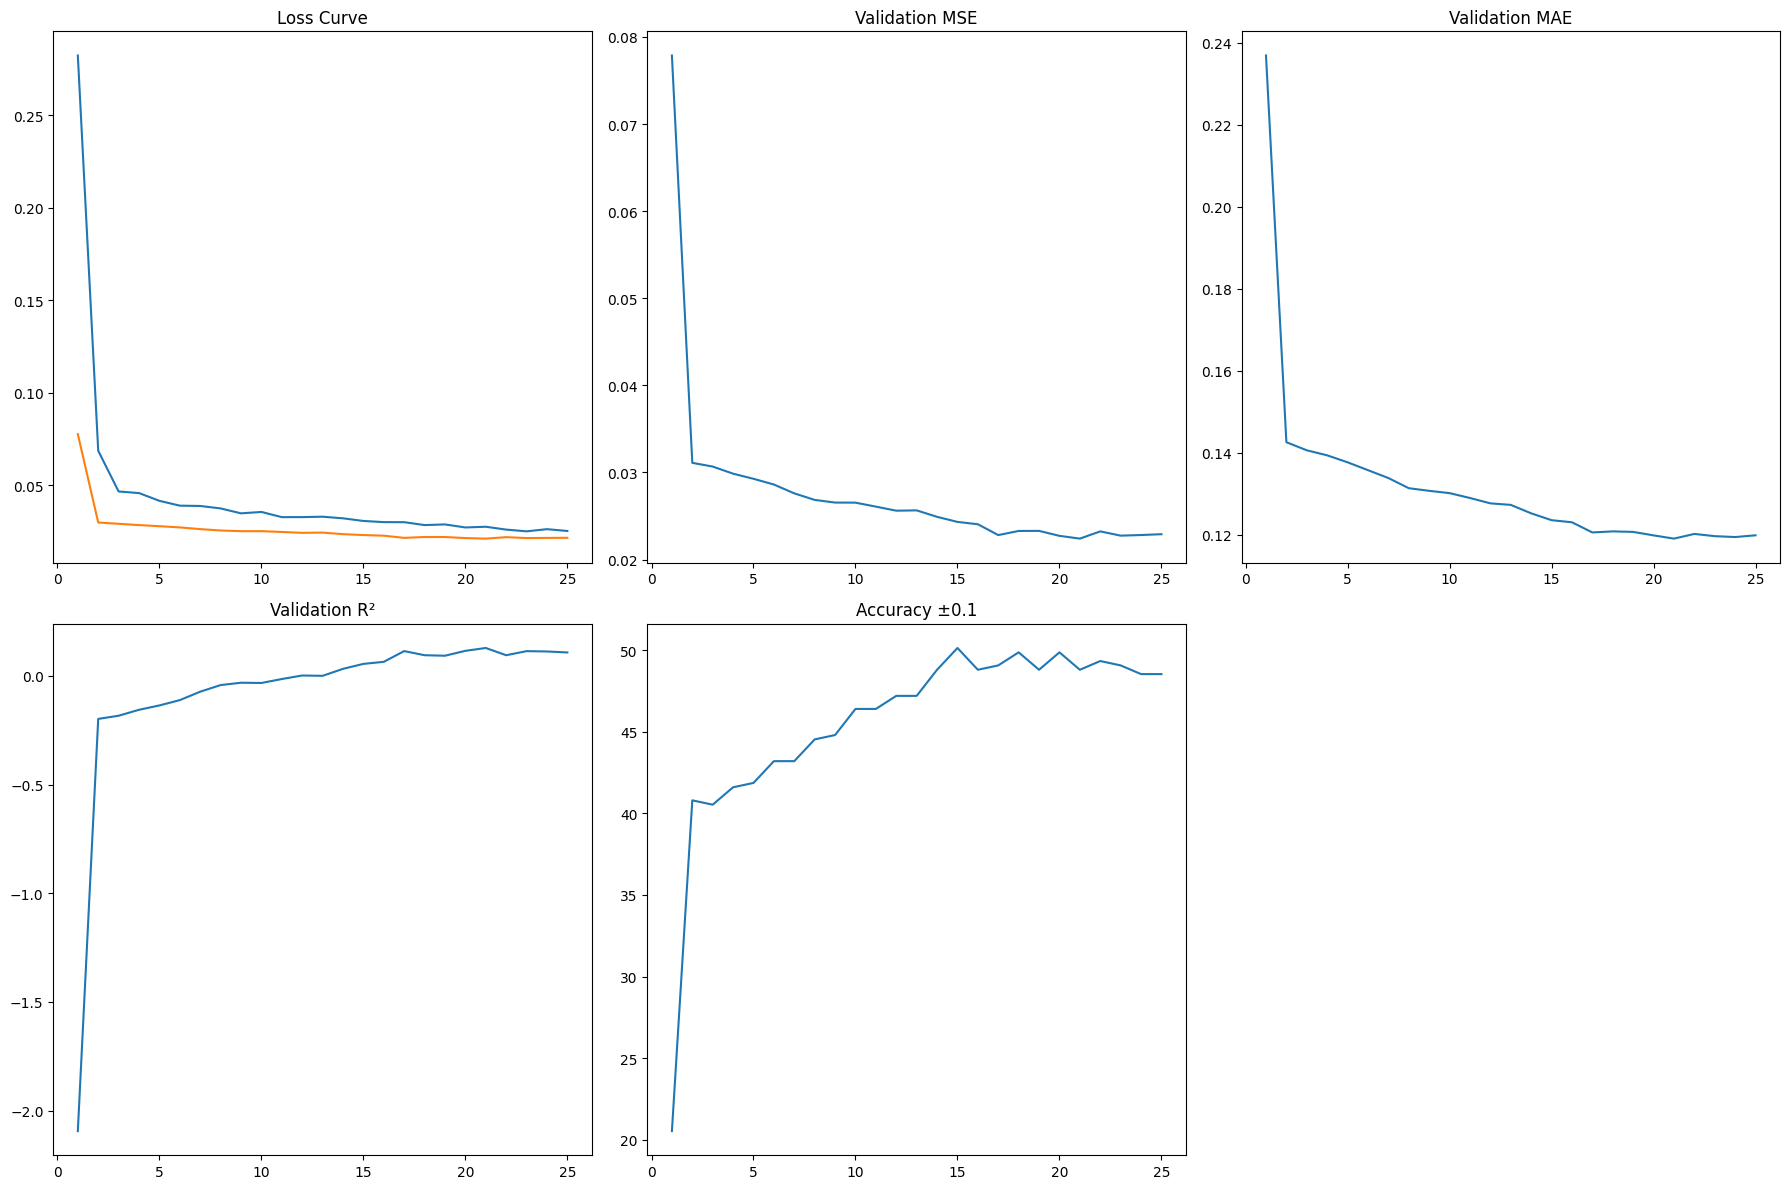


================= FINAL TEST RESULTS =================
MSE: 0.0158
MAE: 0.0997
R²:  0.0439
Accuracy ±0.1: 57.33%


In [1]:
# ============================================================
# 📦 Install & Imports   (gru + encoder + transformer)
# ============================================================

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




seq_X_path  = "seq_X.npy"
seq_y_path  = "seq_y.npy"
seq_id_path = "seq_id.npy"

print("Loading NumPy feature files (.npy)...")

# np.load is the correct function for .npy files
# seq_X_raw is an array of objects (variable-length sequences), so allow_pickle=True is needed.
seq_X_raw = np.load(seq_X_path, allow_pickle=True)
seq_y_raw = np.load(seq_y_path, allow_pickle=True)
seq_id = np.load(seq_id_path, allow_pickle=True)


# Convert to correct types
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y_cleaned = [arr[0] for arr in seq_y_raw] 
seq_y = np.array(seq_y_cleaned, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f" Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])

# ============================================================
# 🧾 Dataset + Collate
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs  = [item["x"] for item in batch]
    ys  = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)


# ============================================================
# 📊 Train / Val / Test Split
# ============================================================
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 Encoders + BiGRU + Transformer Model
# ============================================================
class OceanEncBiGRUTransformer(nn.Module):
    def __init__(
        self,
        input_dim,
        clip_dim=512,
        audio_dim=187,
        clip_enc_dim=128,
        audio_enc_dim=128,
        d_model=256,
        nhead=8,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.2,
    ):
        super().__init__()

        self.clip_dim = clip_dim
        self.audio_dim = audio_dim
    

        # -------------------------
        # 🔹 Modality Encoders
        # -------------------------
        self.clip_encoder = nn.Sequential(
            nn.Linear(clip_dim, clip_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(clip_enc_dim),
        )

        self.audio_encoder = nn.Sequential(
            nn.Linear(audio_dim, audio_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(audio_enc_dim),
        )



        fused_dim = clip_enc_dim + audio_enc_dim

        self.fuse_proj = nn.Sequential(
            nn.Linear(fused_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
        )

        # -------------------------
        # 🔹 BiGRU
        # -------------------------
        self.bigru = nn.GRU(
            input_size=d_model,
            hidden_size=d_model // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.gru_ln = nn.LayerNorm(d_model)

        # -------------------------
        # 🔹 Transformer
        # -------------------------
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

        # -------------------------
        # 🔹 Regression Head
        # -------------------------
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5),
        )

    def forward(self, x, mask):
        B, T, D = x.shape

        # Split modalities
        x_clip = x[:, :, 0:self.clip_dim]
        x_audio  = x[:, :, self.clip_dim : self.clip_dim + self.audio_dim] # indices 512 to 698

        # Encode modalities
        e_clip = self.clip_encoder(x_clip)
        e_audio  = self.audio_encoder(x_audio)

        fused = torch.cat([e_clip, e_audio], dim=-1)
        fused = self.fuse_proj(fused)

        # BiGRU
        gru_out, _ = self.bigru(fused)
        gru_out = self.gru_ln(gru_out)

        # CLS + Transformer
        cls_tok = self.cls_token.expand(B, 1, -1)
        seq = torch.cat([cls_tok, gru_out], dim=1)

        cls_mask = torch.ones(B, 1, device=mask.device)
        full_mask = torch.cat([cls_mask, mask], dim=1)
        key_mask = (full_mask == 0)

        enc = self.encoder(seq, src_key_padding_mask=key_mask)
        cls_out = enc[:, 0]

        # Predict OCEAN
        return self.head(cls_out)


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 📈 Training Setup
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

model = OceanEncBiGRUTransformer(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
criterion = nn.MSELoss()

train_loss_history = []
val_loss_history   = []

val_mse_history = []
val_mae_history = []
val_r2_history  = []
val_acc_history = []

best_val = float("inf")
patience = 10
pat_ctr = 0
EPOCHS = 25

# ============================================================
# 🏋️ Training Loop
# ============================================================
for epoch in range(1, EPOCHS + 1):

    # -------- TRAIN --------
    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- VALIDATION --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
            preds = model(x, mask)

            loss = criterion(preds, y)
            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        best_state = model.state_dict()
        pat_ctr = 0
    else:
        pat_ctr += 1
        if pat_ctr >= patience:
            print(" Early stopping triggered")
            break

model.load_state_dict(best_state)


# ============================================================
# 📈 Plot Metrics
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_history)
plt.plot(epochs, val_loss_history)
plt.title("Loss Curve")

plt.subplot(2, 3, 2)
plt.plot(epochs, val_mse_history)
plt.title("Validation MSE")

plt.subplot(2, 3, 3)
plt.plot(epochs, val_mae_history)
plt.title("Validation MAE")

plt.subplot(2, 3, 4)
plt.plot(epochs, val_r2_history)
plt.title("Validation R²")

plt.subplot(2, 3, 5)
plt.plot(epochs, val_acc_history)
plt.title("Accuracy ±0.1")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 Final Test Evaluation
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)
        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")

Loading NumPy feature files (.npy)...
 Loaded 500 videos
Example X shape: (31, 699)
Example y: [0.36666667 0.5825243  0.34579438 0.47252747 0.375     ]
Example id: zEyRyTnIw5I.005.mp4
Train: 350 | Val: 75 | Test: 75
Using: cuda
Epoch 1 | Train 0.2277 | Val 0.0466 | MSE 0.0472 | MAE 0.1827 | R² -1.4631 | Acc±0.1 29.87%
Epoch 2 | Train 0.0576 | Val 0.0235 | MSE 0.0239 | MAE 0.1254 | R² -0.2448 | Acc±0.1 47.47%
Epoch 3 | Train 0.0446 | Val 0.0233 | MSE 0.0237 | MAE 0.1248 | R² -0.2402 | Acc±0.1 47.73%
Epoch 4 | Train 0.0415 | Val 0.0224 | MSE 0.0228 | MAE 0.1227 | R² -0.1938 | Acc±0.1 48.80%
Epoch 5 | Train 0.0385 | Val 0.0210 | MSE 0.0215 | MAE 0.1185 | R² -0.1219 | Acc±0.1 49.33%
Epoch 6 | Train 0.0396 | Val 0.0205 | MSE 0.0211 | MAE 0.1178 | R² -0.0972 | Acc±0.1 50.93%
Epoch 7 | Train 0.0375 | Val 0.0203 | MSE 0.0209 | MAE 0.1176 | R² -0.0937 | Acc±0.1 49.87%
Epoch 8 | Train 0.0357 | Val 0.0192 | MSE 0.0198 | MAE 0.1132 | R² -0.0311 | Acc±0.1 51.47%
Epoch 9 | Train 0.0332 | Val 0.0191 

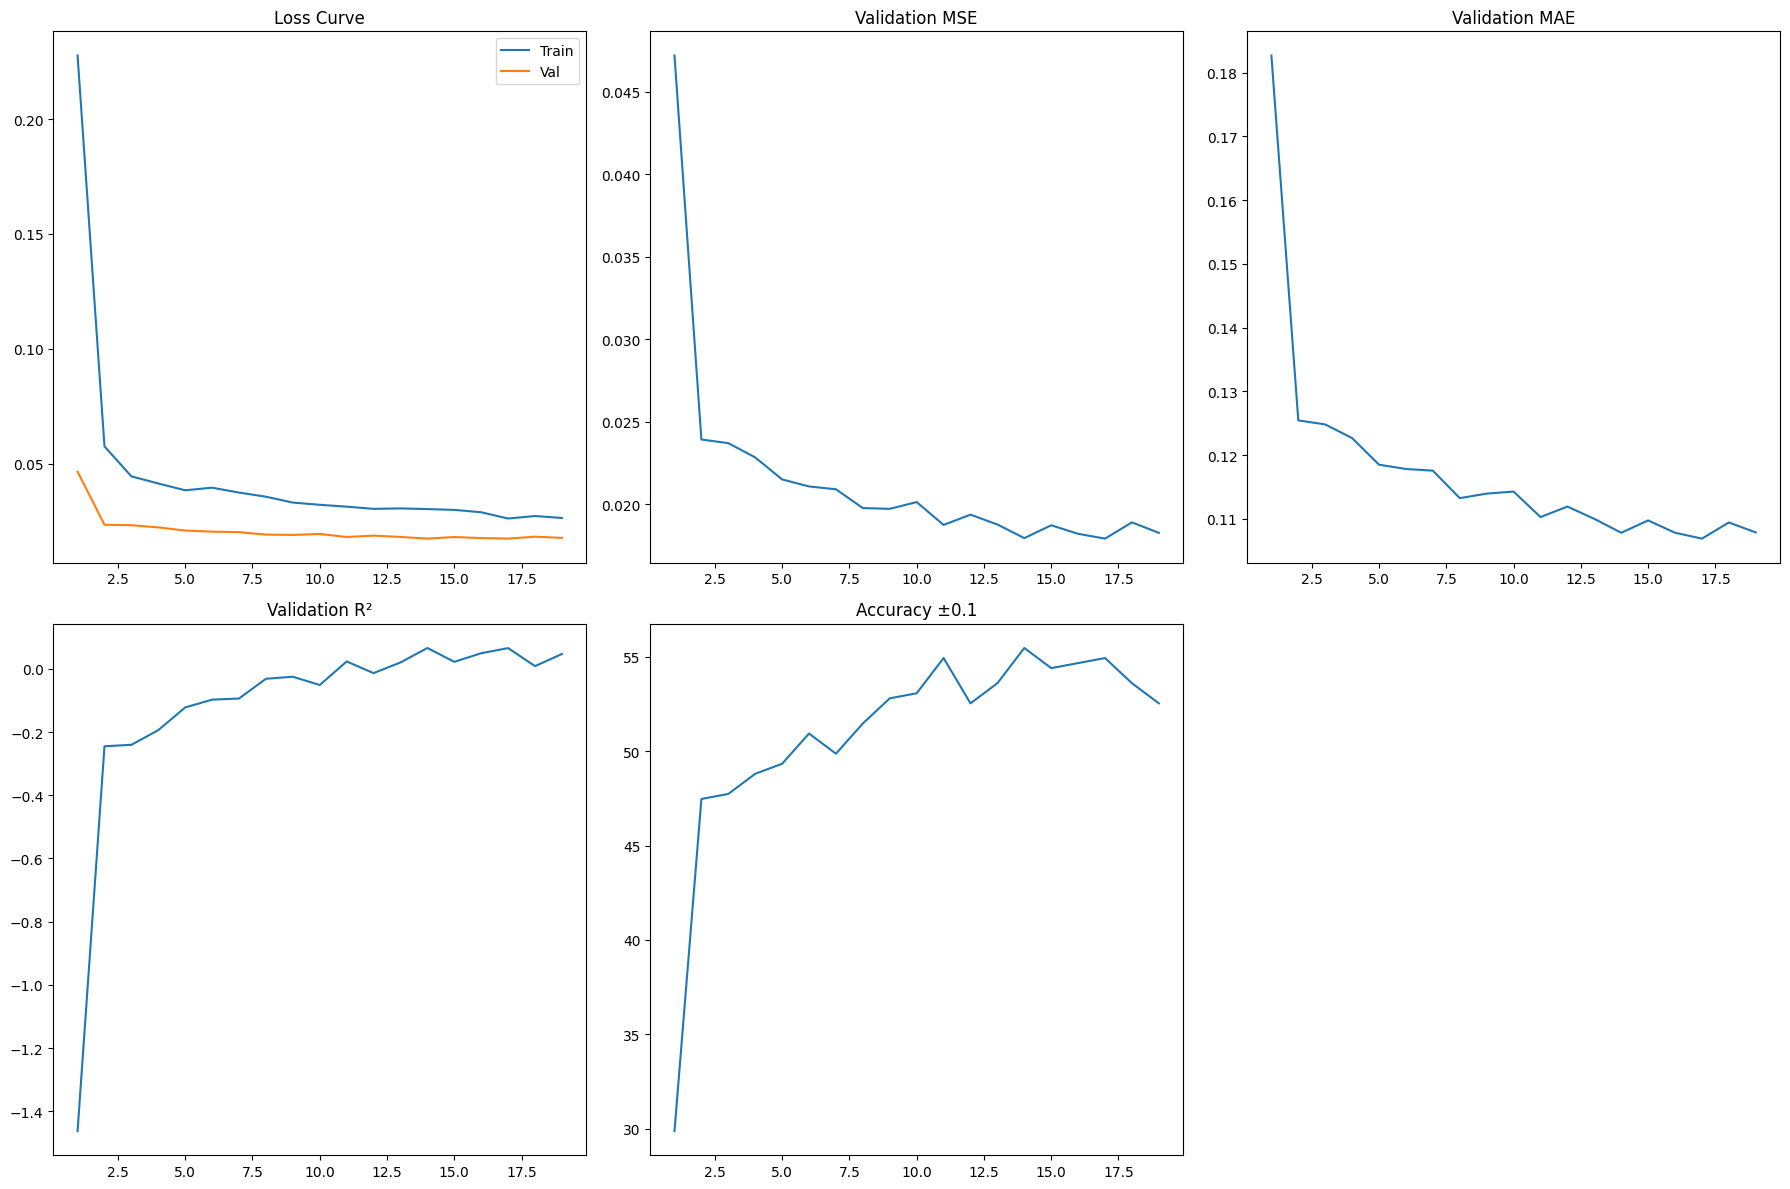


================= FINAL TEST RESULTS =================
MSE: 0.0186
MAE: 0.1084
R²:  0.0550
Accuracy ±0.1: 54.13%


In [2]:
#HCAFT
# ============================================================
# 📦 Install & Imports
# ============================================================


import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# ============================================================
# 📂 Paths
# ============================================================
seq_X_path  = "seq_X.npy"
seq_y_path  = "seq_y.npy"
seq_id_path = "seq_id.npy"

print("Loading NumPy feature files (.npy)...")

# np.load is the correct function for .npy files
# seq_X_raw is an array of objects (variable-length sequences), so allow_pickle=True is needed.
seq_X_raw = np.load(seq_X_path, allow_pickle=True)
seq_y_raw = np.load(seq_y_path, allow_pickle=True)
seq_id = np.load(seq_id_path, allow_pickle=True)


# Convert to correct types
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y_cleaned = [arr[0] for arr in seq_y_raw] 
seq_y = np.array(seq_y_cleaned, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f" Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])



# ============================================================
# 🧾 Dataset + Collate
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs  = [item["x"] for item in batch]
    ys  = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)


# ============================================================
# 📊 Train / Val / Test Split
# ============================================================
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 HCAFT: Encoders + Cross-Attention + BiGRU + Transformer
# ============================================================
class CrossAttentionBlock(nn.Module):
    """
    Simple cross-attention block:
    Q attends to K,V using MultiheadAttention.
    """
    def __init__(self, dim, nhead=4, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=dim, num_heads=nhead, dropout=dropout, batch_first=True)
        self.ln = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.ReLU(),
            nn.Linear(dim * 2, dim),
        )
        self.ff_ln = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, key_padding_mask=None):
        # q,k,v: (B, T, dim)
        attn_out, _ = self.mha(q, k, v, key_padding_mask=key_padding_mask)
        x = self.ln(q + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.ff_ln(x + self.dropout(ff_out))
        return x


class OceanHCAFT(nn.Module):
    def __init__(
        self,
        input_dim,
        clip_dim=512,
        wav_dim=187,
        clip_enc_dim=128,
        wav_enc_dim=128,
        d_model=256,
        nhead_xattn=4,
        nhead_transformer=8,
        num_layers_transformer=2,
        dim_feedforward=512,
        dropout=0.2,
    ):
        super().__init__()

        self.clip_dim = clip_dim
        self.wav_dim = wav_dim


        # -------------------------
        # 🔹 1. Modality Encoders (frame-level)
        # -------------------------
        self.clip_encoder = nn.Sequential(
            nn.Linear(clip_dim, clip_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(clip_enc_dim),
        )

        self.wav_encoder = nn.Sequential(
            nn.Linear(wav_dim, wav_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(wav_enc_dim),
        )

        # -------------------------
        # 🔹 2. Cross-Attention Fusion (frame-level)
        # CLIP ↔ Audio (Wav2Vec2)
        # -------------------------
        # Q = CLIP, K,V = Audio
        self.cross_clip_from_audio = CrossAttentionBlock(clip_enc_dim, nhead=nhead_xattn, dropout=dropout)
        # Q = Audio, K,V = CLIP
        self.cross_audio_from_clip = CrossAttentionBlock(wav_enc_dim, nhead=nhead_xattn, dropout=dropout)

        fused_dim = clip_enc_dim + wav_enc_dim 

        self.fuse_proj = nn.Sequential(
            nn.Linear(fused_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
        )

        # -------------------------
        # 🔹 3. BiGRU (segment / local temporal modeling)
        # -------------------------
        self.bigru = nn.GRU(
            input_size=d_model,
            hidden_size=d_model // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.gru_ln = nn.LayerNorm(d_model)

        # -------------------------
        # 🔹 4. Video-level Transformer
        # -------------------------
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_transformer,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers_transformer)

        # -------------------------
        # 🔹 5. OCEAN Regression Head
        # -------------------------
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5),   # O, C, E, A, N
        )

    def forward(self, x, mask):
        """
        x:    (B, T, 1291)
        mask: (B, T) with 1 for valid, 0 for padded
        """
        B, T, D = x.shape

        # -------------------------
        # Split modalities
        # -------------------------
        x_clip = x[:, :, 0:self.clip_dim]  # (B, T, 512)
        x_wav  = x[:, :, self.clip_dim :self.clip_dim + self.wav_dim]  # (B, T, 768)

        # -------------------------
        # Frame-level encoding
        # -------------------------
        e_clip = self.clip_encoder(x_clip)    # (B, T, clip_enc_dim)
        e_wav  = self.wav_encoder(x_wav)      # (B, T, wav_enc_dim)

        # -------------------------
        # Cross-Attention: CLIP ↔ Audio
        # -------------------------
        # Prepare key padding masks: True where PAD
        key_padding = (mask == 0)  # (B, T)

        # CLIP attends to Audio
        clip_from_audio = self.cross_clip_from_audio(
            q=e_clip,
            k=e_wav,
            v=e_wav,
            key_padding_mask=key_padding
        )  # (B, T, clip_enc_dim)

        # Audio attends to CLIP
        audio_from_clip = self.cross_audio_from_clip(
            q=e_wav,
            k=e_clip,
            v=e_clip,
            key_padding_mask=key_padding
        )  # (B, T, wav_enc_dim)

        # Fuse all enriched features
        fused = torch.cat(
            [clip_from_audio, audio_from_clip],
            dim=-1
        )  # (B, T, fused_dim)

        fused = self.fuse_proj(fused)  # (B, T, d_model)

        # -------------------------
        # BiGRU for local temporal modeling
        # -------------------------
        gru_out, _ = self.bigru(fused)  # (B, T, d_model) since bidirectional
        gru_out = self.gru_ln(gru_out)

        # -------------------------
        # Video-level Transformer with [CLS]
        # -------------------------
        cls_tok = self.cls_token.expand(B, 1, -1)  # (B, 1, d_model)
        seq = torch.cat([cls_tok, gru_out], dim=1)  # (B, T+1, d_model)

        cls_mask = torch.ones(B, 1, device=mask.device)
        full_mask = torch.cat([cls_mask, mask], dim=1)  # (B, T+1)
        key_padding_mask = (full_mask == 0)  # True where pad

        enc = self.encoder(seq, src_key_padding_mask=key_padding_mask)  # (B, T+1, d_model)
        cls_out = enc[:, 0]  # (B, d_model)

        # -------------------------
        # OCEAN prediction
        # -------------------------
        out = self.head(cls_out)  # (B, 5)
        return out


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 📈 Training Setup
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

model = OceanHCAFT(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
criterion = nn.MSELoss()

train_loss_history = []
val_loss_history   = []

val_mse_history = []
val_mae_history = []
val_r2_history  = []
val_acc_history = []

best_val = float("inf")
patience = 5
pat_ctr = 0
EPOCHS = 25

# ============================================================
# 🏋️ Training Loop
# ============================================================
for epoch in range(1, EPOCHS + 1):

    # -------- TRAIN --------
    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- VALIDATION --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
            preds = model(x, mask)

            loss = criterion(preds, y)
            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        best_state = model.state_dict()
        pat_ctr = 0
    else:
        pat_ctr += 1
        if pat_ctr >= patience:
            print("Early stopping triggered")
            break
        
model_path = "ocean_HCAFT_transformer_best.pth"
torch.save(best_state, model_path)
print(f"Best model saved to {model_path}")

model.load_state_dict(best_state)


# ============================================================
# 📈 Plot Metrics
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_history, label="Train")
plt.plot(epochs, val_loss_history, label="Val")
plt.title("Loss Curve")
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, val_mse_history)
plt.title("Validation MSE")

plt.subplot(2, 3, 3)
plt.plot(epochs, val_mae_history)
plt.title("Validation MAE")

plt.subplot(2, 3, 4)
plt.plot(epochs, val_r2_history)
plt.title("Validation R²")

plt.subplot(2, 3, 5)
plt.plot(epochs, val_acc_history)
plt.title("Accuracy ±0.1")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 Final Test Evaluation
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)
        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")

Loading NumPy feature files (.npy)...
 Loaded 500 videos
Example X shape: (31, 699)
Example y: [0.36666667 0.5825243  0.34579438 0.47252747 0.375     ]
Example id: zEyRyTnIw5I.005.mp4
Train: 350 | Val: 75 | Test: 75
Using: cuda
Epoch 1 | Train 0.2542 | Val 0.0331 | MSE 0.0339 | MAE 0.1459 | R² -0.4705 | Acc±0.1 42.40%
Epoch 2 | Train 0.0513 | Val 0.0266 | MSE 0.0278 | MAE 0.1290 | R² -0.2201 | Acc±0.1 48.27%
Epoch 3 | Train 0.0461 | Val 0.0259 | MSE 0.0270 | MAE 0.1269 | R² -0.1935 | Acc±0.1 49.87%
Epoch 4 | Train 0.0419 | Val 0.0238 | MSE 0.0249 | MAE 0.1226 | R² -0.0941 | Acc±0.1 51.20%
Epoch 5 | Train 0.0405 | Val 0.0226 | MSE 0.0237 | MAE 0.1196 | R² -0.0346 | Acc±0.1 51.47%
Epoch 6 | Train 0.0386 | Val 0.0225 | MSE 0.0235 | MAE 0.1196 | R² -0.0200 | Acc±0.1 52.80%
Epoch 7 | Train 0.0382 | Val 0.0213 | MSE 0.0223 | MAE 0.1166 | R² 0.0248 | Acc±0.1 54.40%
Epoch 8 | Train 0.0360 | Val 0.0217 | MSE 0.0227 | MAE 0.1173 | R² 0.0032 | Acc±0.1 53.87%
Epoch 9 | Train 0.0351 | Val 0.0227 | 

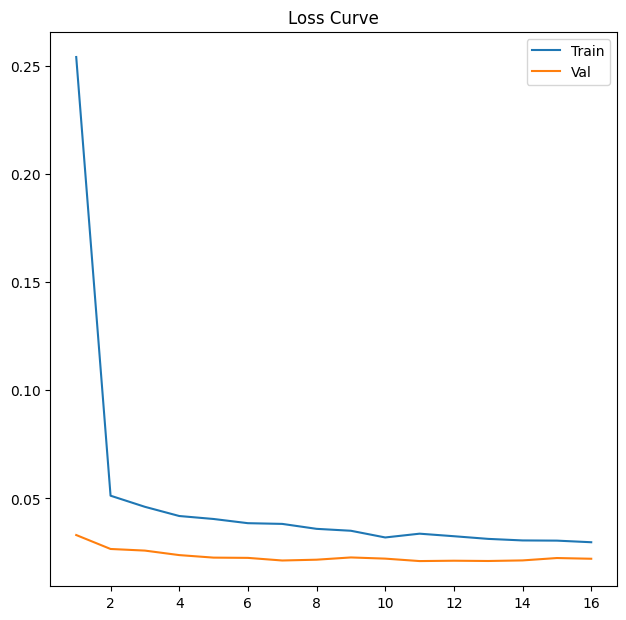


================= FINAL TEST RESULTS =================
MSE: 0.0223
MAE: 0.1152
R²:  -0.0755
Accuracy ±0.1: 54.13%


In [3]:
# ============================================================
# 📦 Install & Imports (1DConv)


import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#

seq_X_path  = "seq_X.npy"
seq_y_path  = "seq_y.npy"
seq_id_path = "seq_id.npy"

print("Loading NumPy feature files (.npy)...")

# np.load is the correct function for .npy files
# seq_X_raw is an array of objects (variable-length sequences), so allow_pickle=True is needed.
seq_X_raw = np.load(seq_X_path, allow_pickle=True)
seq_y_raw = np.load(seq_y_path, allow_pickle=True)
seq_id = np.load(seq_id_path, allow_pickle=True)


# Convert to correct types
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y_cleaned = [arr[0] for arr in seq_y_raw] 
seq_y = np.array(seq_y_cleaned, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f" Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])



class OceanDataset(Dataset):
    # FIX: Change _init_ to __init__
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    # FIX: Change _len_ to __len__
    def __len__(self):
        return len(self.X_list)

    # FIX: Change _getitem_ to __getitem__
    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }



def collate_fn(batch):

    xs = [item["x"] for item in batch]

    ys = [item["y"] for item in batch]

    ids = [item["id"] for item in batch]



    lengths = [x.shape[0] for x in xs]

    max_len = max(lengths)

    feat_dim = xs[0].shape[1]

    B = len(xs)



    padded_x = torch.zeros(B, max_len, feat_dim)

    mask = torch.zeros(B, max_len)



    for i, x in enumerate(xs):

        T = x.shape[0]

        padded_x[i, :T] = x

        mask[i, :T] = 1



    y = torch.stack(ys, dim=0).squeeze(1)



    return {"x": padded_x, "y": y, "mask": mask, "id": ids}



dataset = OceanDataset(seq_X, seq_y, seq_id)



# ============================================================

# Train / Val / Test Split

# ============================================================

train_size = int(0.7 * N)

val_size   = int(0.15 * N)

test_size  = N - train_size - val_size



train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])



train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)

val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)

test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)



print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")



# ============================================================

# 🧠 Conv1D + Transformer Model

# ============================================================
# ============================================================
# 🧠 Conv1D + Transformer Model (CORRECTED)
# ============================================================
class OceanConvTransformer(nn.Module):
    # FIX 1: Change _init_ to __init__
    def __init__(self, input_dim, d_model=256, nhead=8,
                     num_layers=3, dim_feedforward=512, dropout=0.2):
        # FIX 2: Change super()._init_() to super().__init__()
        super().__init__()

        # Project input → transformer dimension
        self.input_proj = nn.Linear(input_dim, d_model)

        # Local temporal modeling
        self.conv = nn.Sequential(
            nn.Conv1d(d_model, d_model, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(d_model, d_model, 3, padding=1),
            nn.ReLU(),
        )

        # CLS Token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        # Transformer encoder
        layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

        # Regression head
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5),
        )


    def forward(self, x, mask):

        B, T, _ = x.shape



        # Input projection

        x = self.input_proj(x)



        # Conv1D expects (B, C, T)

        x = x.permute(0, 2, 1)

        x = self.conv(x)

        x = x.permute(0, 2, 1)



        cls_tok = self.cls_token.expand(B, 1, -1)

        x = torch.cat([cls_tok, x], dim=1)



        # Mask: 1=real, 0=pad → transformer expects True for pad

        cls_mask = torch.ones(B, 1, device=mask.device)

        full_mask = torch.cat([cls_mask, mask], dim=1)

        key_mask = (full_mask == 0)



        x = self.encoder(x, src_key_padding_mask=key_mask)



        cls_out = x[:, 0]

        return self.head(cls_out)



# ============================================================

# 📏 Metrics

# ============================================================

def compute_metrics(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)

    mae = mean_absolute_error(y_true, y_pred)

    r2  = r2_score(y_true, y_pred)

    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100

    return mse, mae, r2, acc



# ============================================================
# 🏋️ Training Loop (MODIFIED)
# ============================================================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

model = OceanConvTransformer(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
criterion = nn.MSELoss()

best_val = float("inf")
patience = 5
pat_ctr = 0

EPOCHS = 25

# --- New: Lists to store history for plotting ---
train_history = []
val_history = []
# -------------------------------------------------

for epoch in range(1, EPOCHS + 1):
    # -------- Train --------
    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # -------- Val --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
            preds = model(x, mask)
            loss = criterion(preds, y)
            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy().squeeze())
            y_pred.append(preds.cpu().numpy().squeeze())

    avg_train = np.mean(train_losses)
    avg_val = np.mean(val_losses)
    
    # --- New: Append to history lists ---
    train_history.append(avg_train)
    val_history.append(avg_val)
    # ------------------------------------

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")

    if avg_val < best_val:
        best_val = avg_val
        best_state = model.state_dict()
        pat_ctr = 0
    else:
        pat_ctr += 1
        if pat_ctr >= patience:
            print(" Early stopping")
            break


# Load best model

model.load_state_dict(best_state)



# ============================================================

# 🧪 Test Evaluation

# ============================================================

model.eval()

true_list, pred_list = [], []

# ============================================================
# 📊 Loss Curve Plot
# ============================================================

# Determine the number of completed epochs (up to early stopping)
epochs = range(1, len(train_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_history, label="Train")
plt.plot(epochs, val_history, label="Val")
plt.title("Loss Curve")
plt.legend()
plt.tight_layout()
plt.show()



with torch.no_grad():

    for batch in test_loader:

        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        preds = model(x, mask)

        true_list.append(y.cpu().numpy())

        pred_list.append(preds.cpu().numpy())



true_list = np.vstack(true_list)

pred_list = np.vstack(pred_list)


mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")

print(f"MSE: {mse:.4f}")

print(f"MAE: {mae:.4f}")

print(f"R²:  {r2:.4f}")

print(f"Accuracy ±0.1: {acc:.2f}%")

In [ ]:
# ===============================================================
# 🎥 Frame-Level Feature Extraction (FIRST 500 VIDEOS ONLY)
# MTCNN + InceptionResnetV1 + Librosa (WITH CHECKPOINT + RESUME)
# ===============================================================

import os, cv2, torch, librosa, numpy as np, pandas as pd, subprocess, pickle
from tqdm import tqdm
from facenet_pytorch import MTCNN, InceptionResnetV1
import re
from moviepy.editor import VideoFileClip

# ===============================================================
# 🔧 Device Setup
# ===============================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# ===============================================================
# 🔧 Initialize Models
# ===============================================================
mtcnn = MTCNN(image_size=160, margin=0, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# ===============================================================
# 🔧 FFmpeg Audio Extractor
# ===============================================================
def extract_audio_ffmpeg(video_path, target_sr=22050):
    temp_wav = "/tmp/temp_audio.wav"
    cmd = ["ffmpeg", "-y", "-i", video_path, "-ar", str(target_sr), "-ac", "1", temp_wav]
    subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    y, sr = librosa.load(temp_wav, sr=target_sr)
    return y, sr

# ===============================================================
# 🔧 Visual Feature Extraction
# ===============================================================
def extract_visual_features(video_path, frame_skip=10):
    cap = cv2.VideoCapture(video_path)
    frames_embeddings = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_skip == 0:
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            face = mtcnn(rgb)
            if face is not None:
                with torch.no_grad():
                    emb = resnet(face.unsqueeze(0).to(device))
                    frames_embeddings.append(emb.cpu().numpy().flatten())
        frame_count += 1

    cap.release()
    if len(frames_embeddings) == 0:
        return np.zeros((1, 512))  # fallback
    return np.array(frames_embeddings)  # shape: (num_frames, 512)

# ===============================================================
# 🔧 Audio Feature Extraction (MFCC + Chroma + Contrast + Mel)
# ===============================================================
def extract_audio_features(video_path, sr=22050, hop_sec=0.5):
    try:
        clip = VideoFileClip(video_path)
        audio_path = f"temp_audio.wav"
        clip.audio.write_audiofile(audio_path, verbose=False, logger=None)

        y, sr = librosa.load(audio_path, sr=sr)
        hop_length = int(sr * hop_sec)  # frames per window
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, hop_length=hop_length)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=hop_length)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)

        # frame-level audio features
        min_len = min(mfcc.shape[1], chroma.shape[1], contrast.shape[1], mel.shape[1])
        mfcc = mfcc[:, :min_len]
        chroma = chroma[:, :min_len]
        contrast = contrast[:, :min_len]
        mel = mel[:, :min_len]
        audio_features = np.vstack([mfcc, chroma, contrast, mel]).T  # shape: (num_frames, 187)
        return audio_features
    except Exception as e:
        print(f" Audio extraction failed for {video_path}: {e}")
        return np.zeros((1, 187))
# ===============================================================
# 🔧 Combined Feature Extraction
# ===============================================================
def extract_frame_features(video_path):
    visual = extract_visual_features(video_path)
    audio = extract_audio_features(video_path)

    num_frames = min(len(visual), len(audio))
    if num_frames == 0:
        return np.zeros((1, 512+187))

    combined = np.concatenate([visual[:num_frames], audio[:num_frames]], axis=1)
    return combined  # shape: (num_frames, 699)

# ===============================================================
# 📂 Dataset Setup
# ===============================================================
csv_path = "subset_annotations.csv"
video_folder = "Video Interview"
df = pd.read_csv(csv_path)
print("Dataset:", df.shape)

# 🔥 USE ONLY FIRST 500 VIDEOS
df = df.iloc[:500].reset_index(drop=True)
print("Processing FIRST 500 videos only!")

# ===============================================================
# 📦 Checkpoint Paths
# ===============================================================
ckpt_X = "frame_X_ckpt.pkl"
ckpt_y = "frame_y_ckpt.pkl"
ckpt_ids = "frame_ids_ckpt.pkl"
ckpt_done = "frame_done_ids.pkl"

# ===============================================================
# 🔄 Resume Logic
# ===============================================================
if os.path.exists(ckpt_done):
    print(" Resuming from checkpoint...")
    X_list = pickle.load(open(ckpt_X, "rb"))
    y_list = pickle.load(open(ckpt_y, "rb"))
    ids_list = pickle.load(open(ckpt_ids, "rb"))
    done_ids = pickle.load(open(ckpt_done, "rb"))
else:
    print(" Starting fresh…")
    X_list, y_list, ids_list, done_ids = [], [], [], set()

# ===============================================================
# 🎥 Extraction Loop
# ===============================================================

# Make sure you have 'import re' at the top of your script!

for idx, row in tqdm(df.iterrows(), total=len(df)):

    # FIX 1: Use 'video' column name from CSV
    vid_with_noise = row["video"] 
    
    # FIX 2: Clean the video ID for file finding (as discussed)
    # The cleaned ID is used for finding the file on disk and managing checkpoints
    vid_cleaned = re.sub(r'^[\W\d_]+', '', vid_with_noise)
    
    # Checkpoint logic uses the CLEANED ID for resume functionality
    if vid_cleaned in done_ids:
        continue

    # find video
    video_path = None
    
    # FIX 3: Robust File Search by Listing Directory Contents (Handles disk filename errors)
    # Get the unique base ID (e.g., "yZEb6bdxNY")
    base_id = vid_cleaned.split('.')[0] 
    
    try:
        video_files_in_dir = os.listdir(video_folder)
    except FileNotFoundError:
        print(f"Error: Video folder '{video_folder}' not found.")
        continue

    # Search for a match in the directory listing
    for filename in video_files_in_dir:
        # Perform a case-insensitive check to see if the base ID is contained in the filename
        if base_id.lower() in filename.lower():
            # Found a match!
            video_path = os.path.join(video_folder, filename)
            break

    if video_path is None:
        print("Missing:", vid_with_noise, f"(Cleaned Base ID: {base_id}) - File not found in folder.")
        continue

    feats = extract_frame_features(video_path)
    T = len(feats)

    # FIX 4: Correct column names to lowercase (e.g., "Openness" -> "openness")
    labels = np.tile([
        row["openness"],
        row["conscientiousness"],
        row["extraversion"],
        row["agreeableness"],
        row["neuroticism"]
    ], (T, 1))

    X_list.append(feats)
    y_list.append(labels)
    
    # FIX 5: Use the ORIGINAL ID (vid_with_noise) for final output/saving
    ids_list.extend([vid_with_noise] * T)

    # Use the CLEANED ID (vid_cleaned) for checkpoint management
    done_ids.add(vid_cleaned)

    # Save every 10 videos
    if len(done_ids) % 10 == 0:
        pickle.dump(X_list, open(ckpt_X, "wb"))
        pickle.dump(y_list, open(ckpt_y, "wb"))
        pickle.dump(ids_list, open(ckpt_ids, "wb"))
        pickle.dump(done_ids, open(ckpt_done, "wb"))
        print(f" Saved checkpoint at {len(done_ids)}/500 videos")
# ===============================================================
#  Final Save
# ===============================================================
# --- STACKED ARRAYS (Optional, but kept for completeness) ---
X = np.vstack(X_list)
y = np.vstack(y_list)
ids = np.array(ids_list)



# Convert the Python lists to NumPy arrays of objects before saving
seq_X_array = np.array(X_list, dtype=object)
seq_y_array = np.array(y_list, dtype=object) # Assuming y_list contains frame-level labels per sequence
seq_id_array = np.array(ids_list, dtype=object) # Saving raw ID list

# Use allow_pickle=True to save the variable-length sequences
np.save("seq_X.npy", seq_X_array, allow_pickle=True)
np.save("seq_y.npy", seq_y_array, allow_pickle=True)
np.save("seq_id.npy", seq_id_array, allow_pickle=True)

print("Shapes:", X.shape, y.shape, ids.shape)
print(" COMPLETED FOR FIRST 500 VIDEOS!")

print("Shapes:", X.shape, y.shape, ids.shape)
print(" COMPLETED FOR FIRST 500 VIDEOS!")